<a href="https://colab.research.google.com/github/Remaaa17/Data_Preprocessing-ML/blob/main/Customer_Clustring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries

import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
import missingno as msno

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
file_path = r"/content/Mall_Customers.csv"
Mall_df = pd.read_csv(file_path)
# Display the first few rows of the DataFrame
print("Mall_Customers DataFrame:")
Mall_df.head()

Mall_Customers DataFrame:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
Mall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
Mall_df.shape

(200, 5)

In [ ]:
misiing_value= Mall_df.isnull().sum()
misiing_value

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

>>**No null values present in the data!**

In [ ]:
Mall_df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [ ]:
Mall_df.rename(columns={
    'Annual Income (k$)': 'Annual_Income',
    'Spending Score (1-100)': 'Spending_Score'
}, inplace=True)

# Display the first few rows of the dataset
Mall_df.head()


,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
Mall_df.describe()

,CustomerID,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


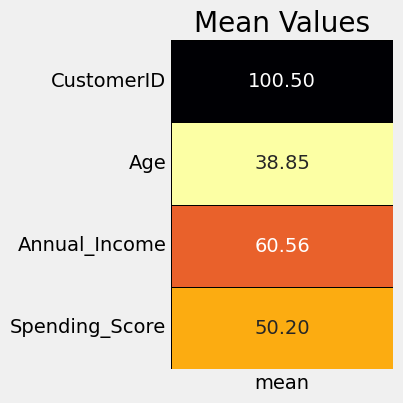

In [ ]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))

plt.subplot(1,1,1)
sns.heatmap(Mall_df.describe().T[['mean']],cmap = 'inferno_r',annot = True,fmt = '.2f',linecolor = 'black',linewidths = 0.4,cbar = False);
plt.title('Mean Values');

fig.tight_layout(pad = 3)

* Average customer Age in the dataset is in the late 30s i.e 38.85.

* Average Annual Income of the customers is 60.56 i.e just short of the 2018 median income of USA citizen, 63k$.

* Spending Score  average of the mall customer is in the center with 50.20.

In [ ]:
px.scatter(data_frame = Mall_df, x = 'Annual_Income', y = 'Spending_Score',
          title = 'Relation between Annual Income and Spending Score')

>>There is no relation between the customers having annual income in the range of 20-40k and 80-140k but there is relation between customers who have annual income in the range of 40-60k.

In [ ]:
col = list(Mall_df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(Mall_df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Gender
Numerical Features : CustomerID Age Annual_Income Spending_Score


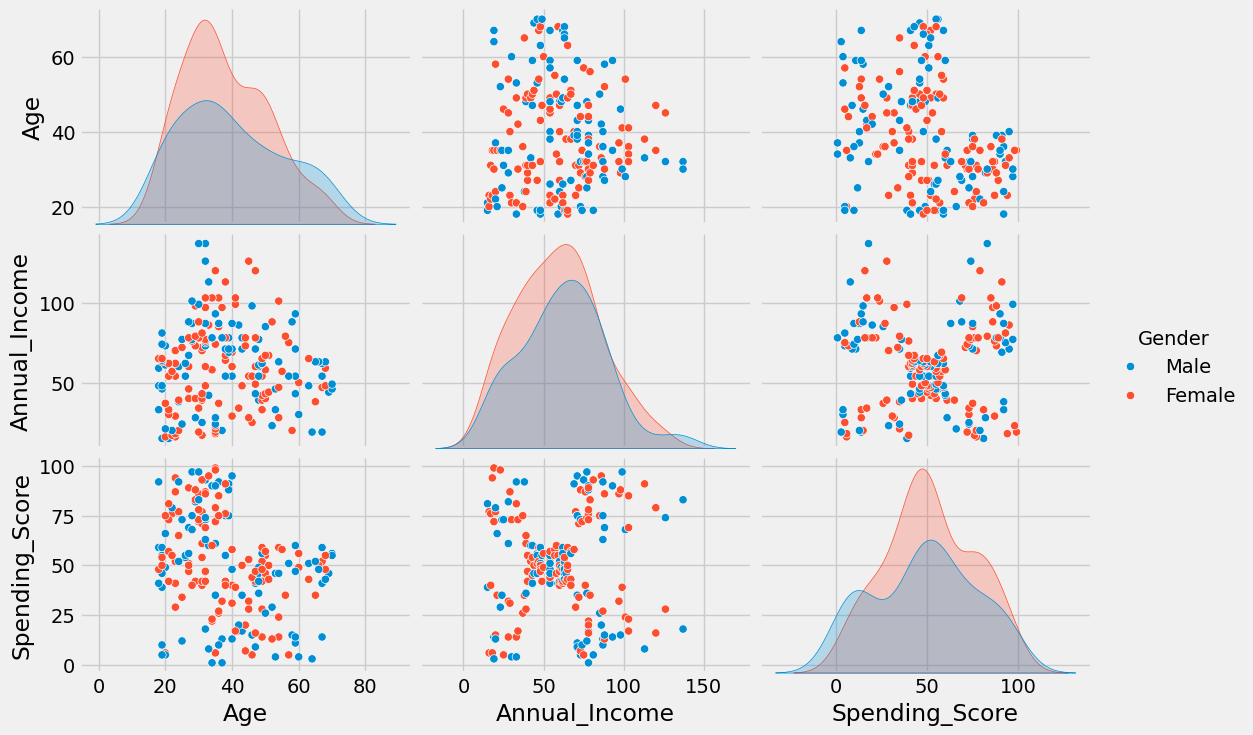

In [ ]:
# Let's see our data in a detailed way with pairplot
X = Mall_df.drop(['CustomerID', 'Gender'], axis=1)
sns.pairplot(Mall_df.drop('CustomerID', axis=1), hue='Gender', aspect=1.5)
plt.show()

>>**From the above plot we see that gender has no direct relation to segmenting customers. That's why we can drop it and move on with other features which is why we will X parameter from now on.**

####Distribution of  Numerical Features :

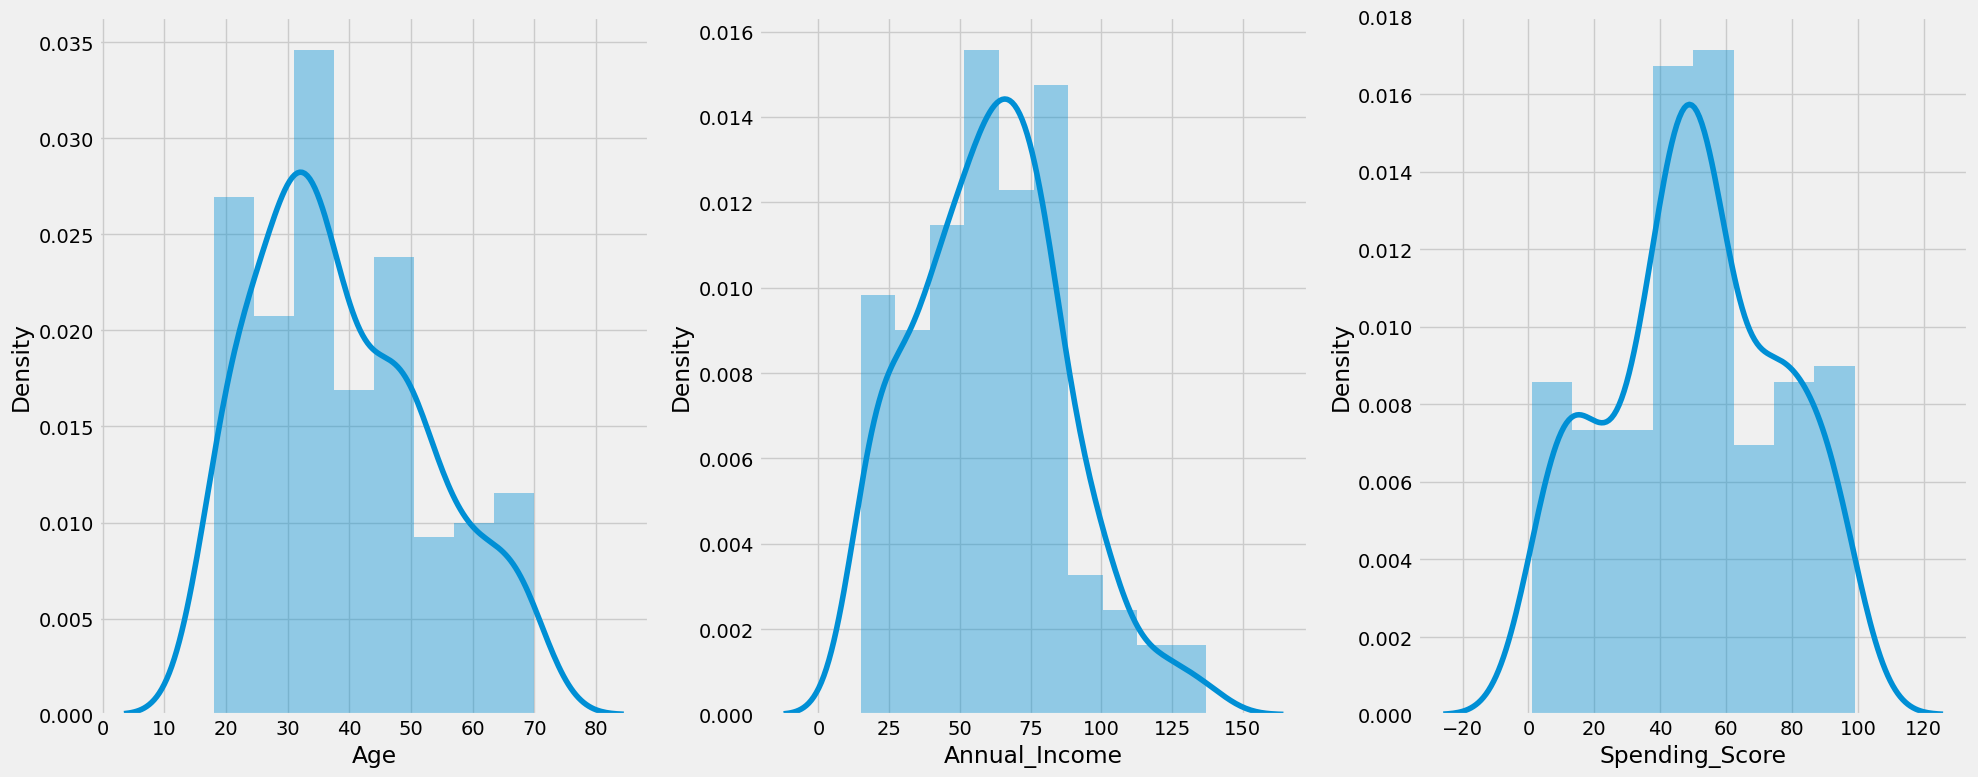

In [ ]:
# distribution plots

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in ['Age', 'Annual_Income', 'Spending_Score']:
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.distplot(Mall_df[col])

    plotnumber += 1

plt.tight_layout()
plt.show()

* Age group near 30-40 have the highest density.
* Most customers have income in range of 50-80k.
* Most of the customers have spending score of 50.


###Target col

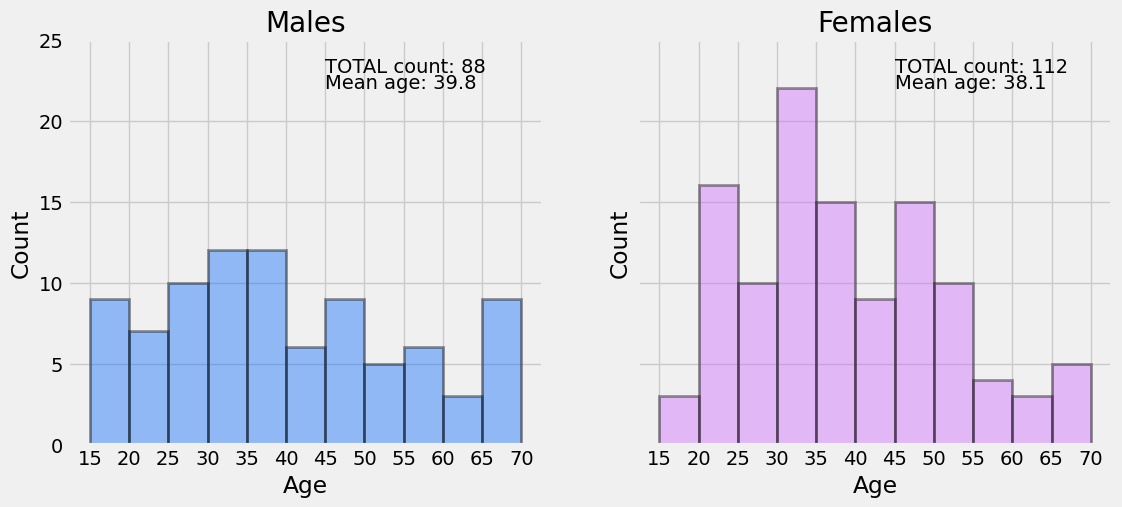

In [ ]:
males_age = Mall_df[Mall_df['Gender']=='Male']['Age'] # subset with males age
females_age = Mall_df[Mall_df['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

>>The average age of male customers is lightly higher than female ones (39.8 versus 38.1). Distribution of male age is more uniform than females, where we can observe that the biggest age group is 30-35 years old. Kolgomorov-Smirnov test shows that the differences between these two groups are statistically insignificant.

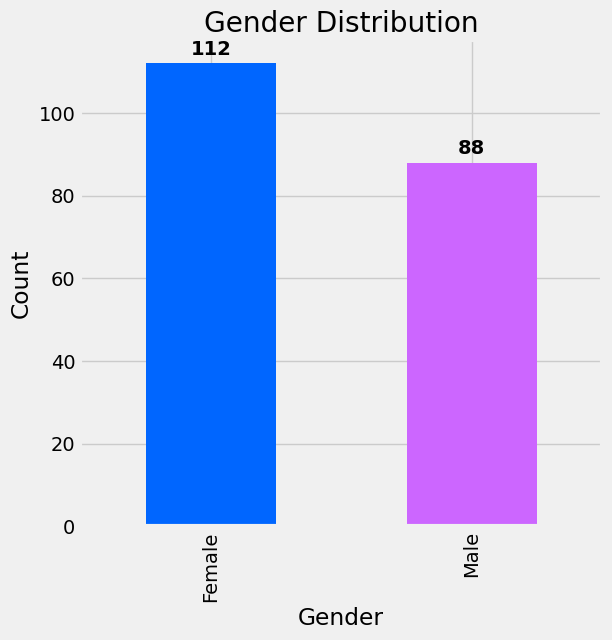

In [ ]:


# Count the number of occurrences of each gender
gender_counts = Mall_df['Gender'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(6, 6))
bars = gender_counts.plot(kind='bar', color=['#0066ff', '#cc66ff'], ax=ax)

# Set the title and labels
ax.set_title('Gender Distribution')
ax.set_xlabel('Gender')
ax.set_ylabel('Count')

# Add the count labels on top of the bars
for bar in bars.patches:
    ax.annotate(f'{bar.get_height()}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom', color='black', fontweight='bold')

# Show the plot
plt.show()


>>There are slightly more female customers than male ones (112 vs. 87). Females are 56% of total customers.

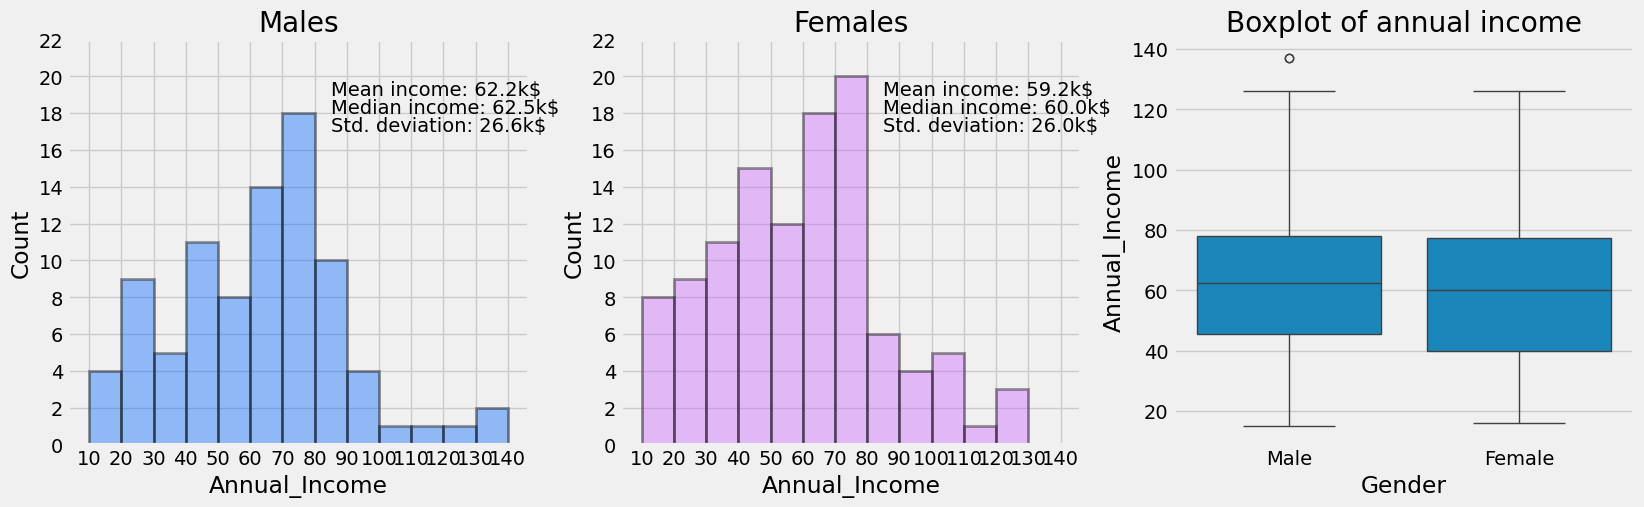

In [ ]:
males_income = Mall_df[Mall_df['Gender']=='Male']['Annual_Income'] # subset with males income
females_income = Mall_df[Mall_df['Gender']=='Female']['Annual_Income'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual_Income', data=Mall_df, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

>>Mean income of males is higher than females (62.2 k$ vs. 59.2k\$). Also median income of male customers (62.5k$) is higher thn female ones (60k\$). Standard deviation is similar for both groups. There is one outlier in male group with an annual income of about 140k$. K-S test shows that these two groups are not statistically different.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Data= Mall_df.copy(deep = True)


Mall_df['Gender'] = le.fit_transform(Mall_df['Gender'])

print('Label Encoder Transformation')
print(Mall_df['Gender'].unique(),' = ',le.inverse_transform(Mall_df['Gender'].unique()))

Label Encoder Transformation
[1 0]  =  ['Male' 'Female']


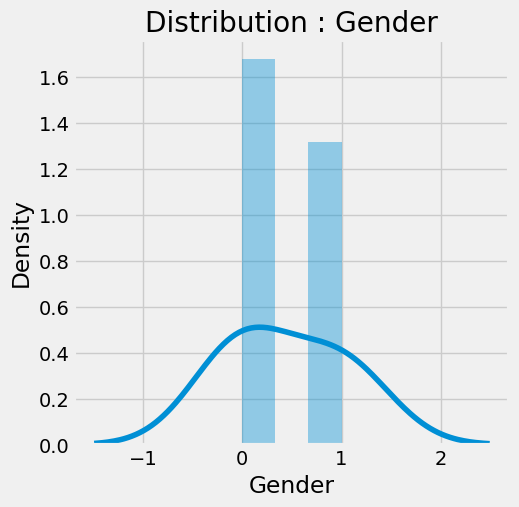

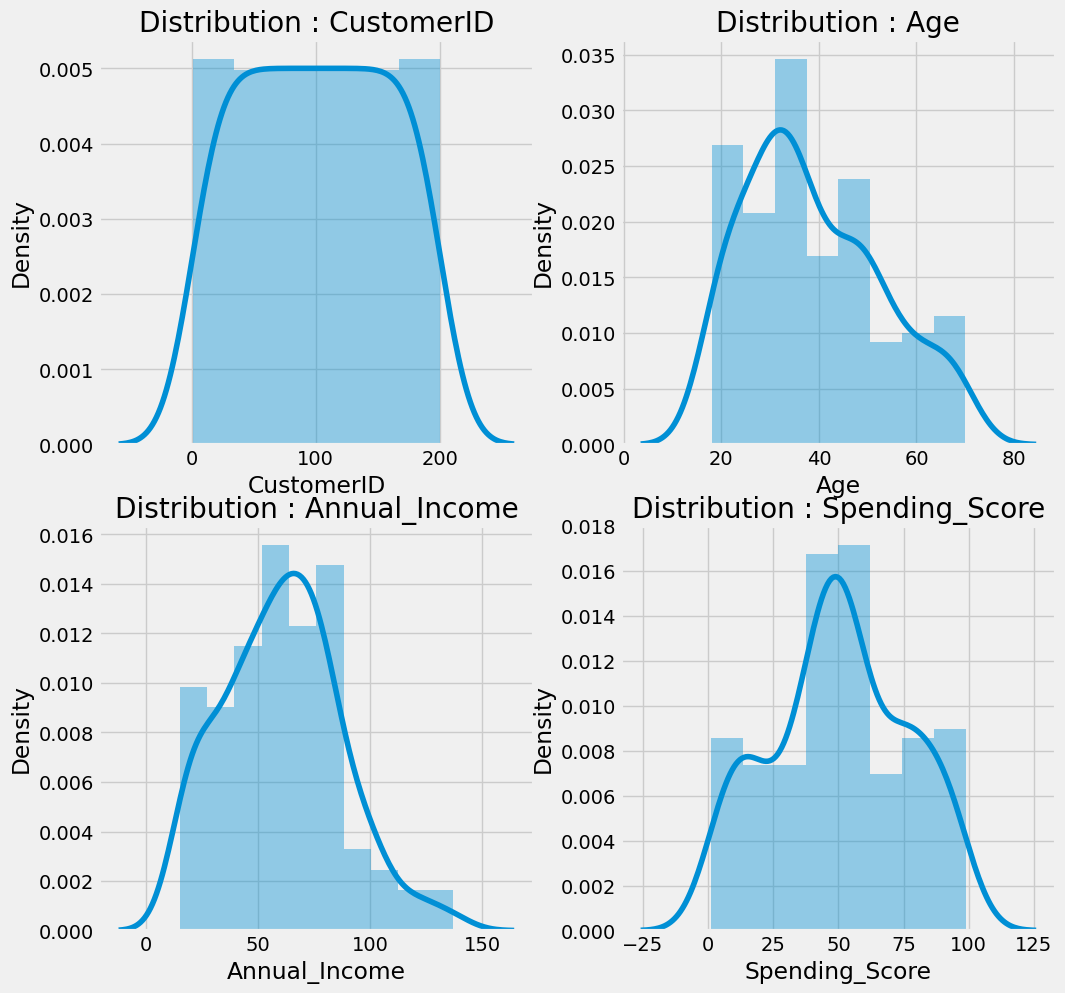

In [ ]:
fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))
for i in range(len(categorical_features)):
    plt.subplot(1,1,i+1)
    sns.distplot(Mall_df[categorical_features[i]],kde_kws = {'bw' : 1});
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (11,11))
for i in range(len(numerical_features)):
    plt.subplot(2,2,i+1)
    sns.distplot(Mall_df[numerical_features[i]],)
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

* Gender, the only categorical feature, data displays a normally distribution.
* Distribution of Age and Annual Income (k$) is positively or righly skewed.
* Spending Score (1-100) data distribution is similar to the Head and Shoulder pattern observed in stock charts.
* It displays a stock's price rising to a peak and then declines back to the base of the prior up-move.
* Something similar can be observed with the 2 shoulders forming around the values 20 & 80 with head being centered in between 40 - 60.
*>>We will drop the CustomerID feature as it is just a number that is tagged to a customer.

###Correlation Matrix :

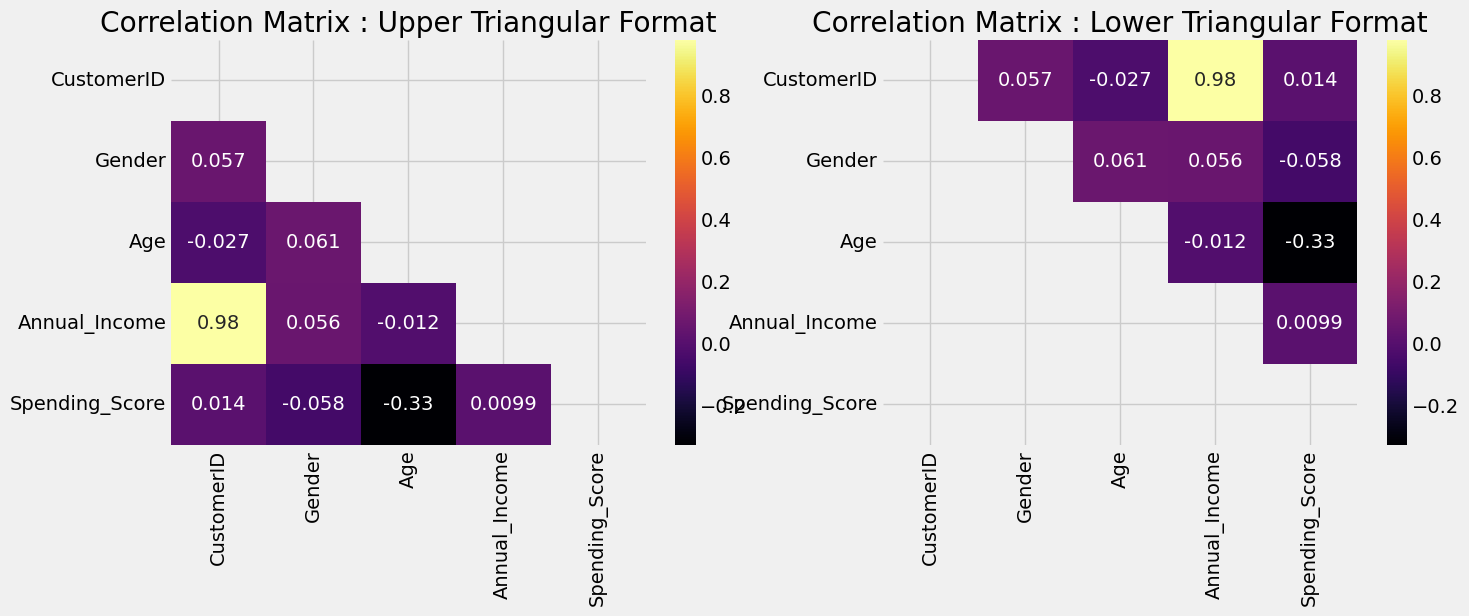

In [ ]:
ut = np.triu(Mall_df.corr())
lt = np.tril(Mall_df.corr())

fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(Mall_df.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

plt.subplot(1,2,2)
sns.heatmap(Mall_df.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = lt);
plt.title('Correlation Matrix : Lower Triangular Format');


* Both the matrix displayed are same! It is only done for visualization
purpose. This trick can be used when the dataset has too many features to look into!
* CustomerID displays a very high positive correlation with Annual Income as the customers are arranged in ascending order according to their Annual Income. We are not going to include CustomerID for modeling purpose.Gender does not display any relation with other features. It is pretty much neutral with all the values sticking to 0.
* Spending Score  and Age display a negative correlation i.e if value of one feature increases, then another feature's value decreases and vice-versa is true!




In [ ]:
# dropping useless column

Mall_df.drop('CustomerID', axis = 1, inplace = True)

#### Data Scalling:

In [ ]:
# Select features and standardize them
features = ["Spending_Score", "Annual_Income", "Age"]

X = Mall_df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Get number of clusters

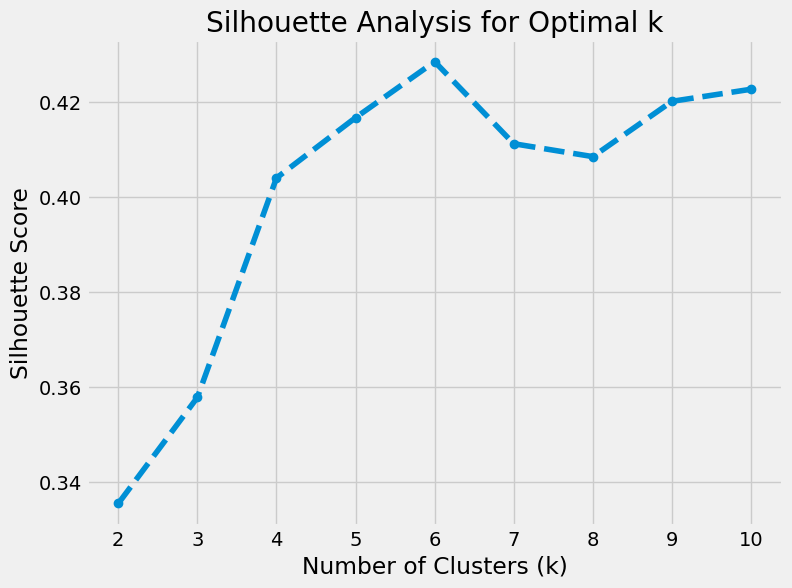

The optimal number of clusters is: 6


In [ ]:
import numpy as np

# Your existing code to calculate silhouette scores and plot them
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Finding the optimal number of clusters
optimal_k = range(2, 11)[np.argmax(silhouette_scores)]
print(f'The optimal number of clusters is: {optimal_k}')


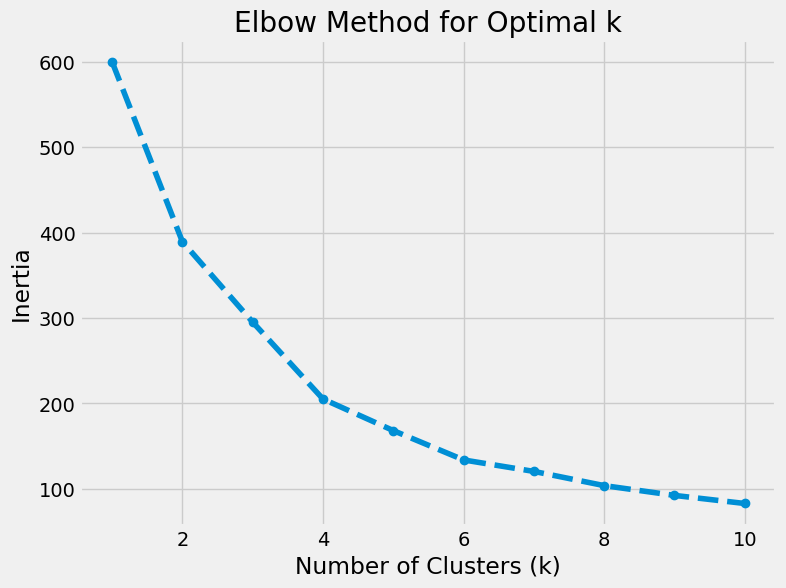

The optimal number of clusters is: 4


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Assuming X_scaled is your standardized data

# Step 2: Run k-means for different k values and calculate inertia
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Step 4: Identify the elbow point using KneeLocator
kneedle = KneeLocator(range(1, 11), inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
print(f'The optimal number of clusters is: {optimal_k}')


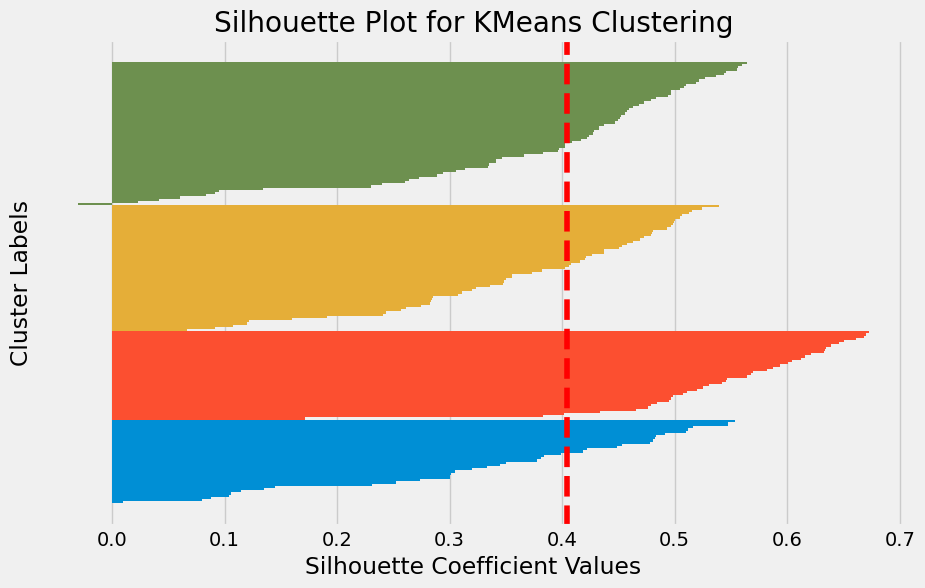

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate silhouette scores
silhouette_vals = silhouette_samples(X_scaled, clusters)

# Plot silhouette plot
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(4):  # Assuming 4 clusters
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    y_lower += len(cluster_silhouette_vals)

silhouette_avg = silhouette_score(X_scaled, clusters)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Plot for KMeans Clustering')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Labels')
plt.yticks([])
plt.show()


>> This mean that  we can use  4 or 6 cluster

###Clustering

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [ ]:
# Apply KMeans Clustering with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
# Add the cluster labels to the original DataFrame
Mall_df['Cluster'] = clusters

print("Clustered Data:\n")
Mall_df.head()

Clustered Data:



,Gender,Age,Annual_Income,Spending_Score,Cluster
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,5
3,Female,23,16,77,0
4,Female,31,17,40,5


In [ ]:
# Create a new DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

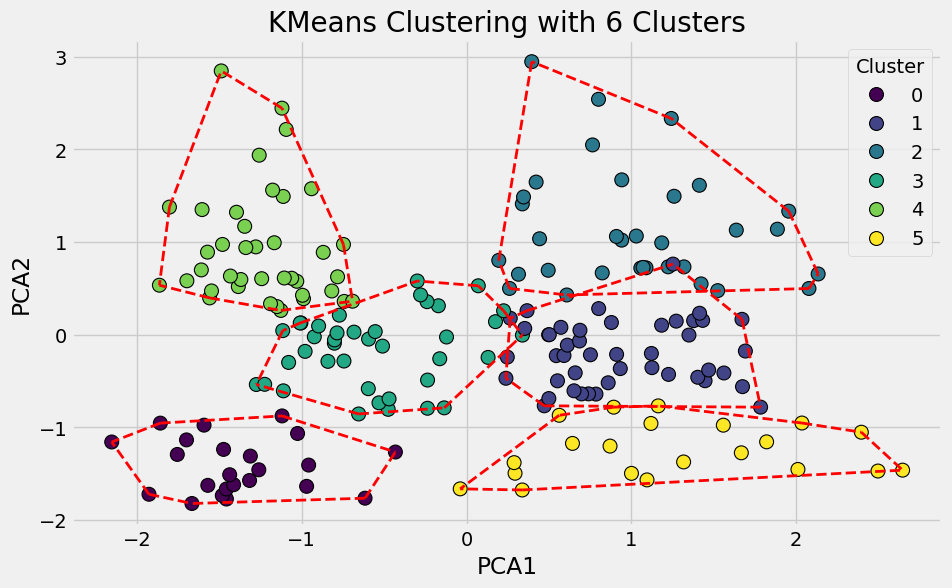

In [ ]:

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, edgecolor='k')

# Draw convex hulls for each cluster
for cluster in pca_df['Cluster'].unique():
    points = pca_df[pca_df['Cluster'] == cluster][['PCA1', 'PCA2']].values
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=2)

plt.title('KMeans Clustering with 6 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

##Try some modles in anothe way


###1. KMeans Clustering

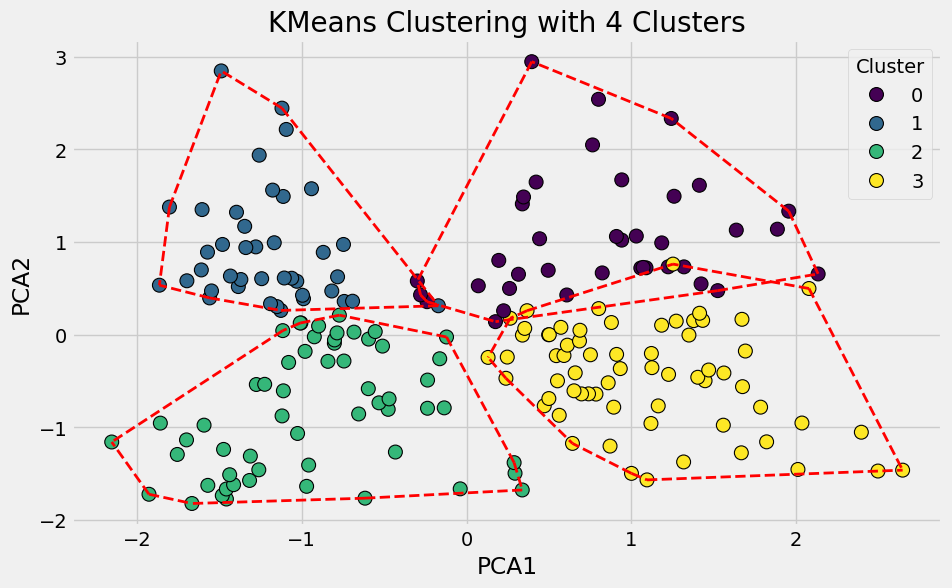

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Load and Prepare Data
url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"
data = pd.read_csv(url)

# Select features and standardize them
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Create a new DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, edgecolor='k')

# Draw convex hulls
for cluster in range(4):
    points = pca_df[pca_df['Cluster'] == cluster][['PCA1', 'PCA2']].values
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=2)

plt.title('KMeans Clustering with 4 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


###2. Hierarchical Clustering (Agglomerative Clustering)

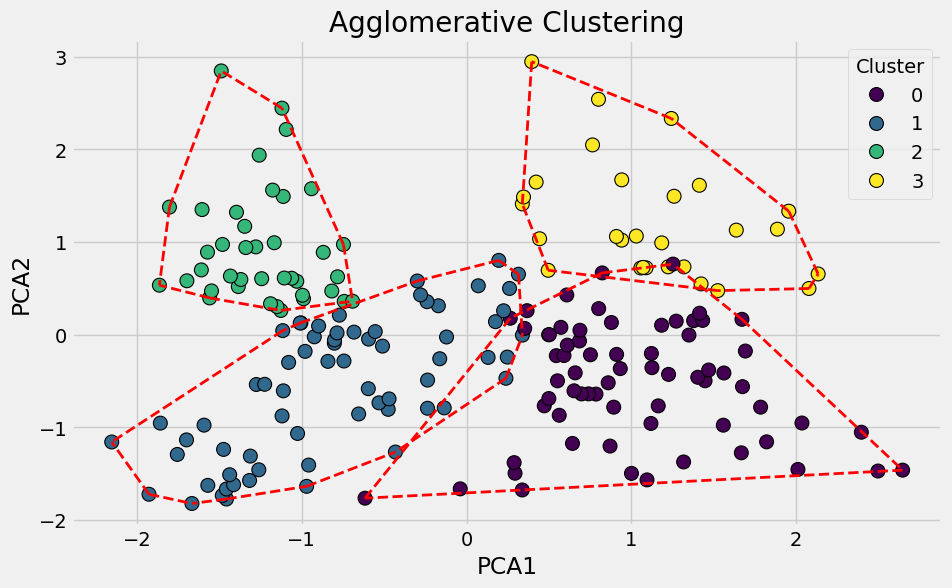

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
clusters = agglo.fit_predict(X_scaled)

# Create a new DataFrame with PCA results and cluster labels
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, edgecolor='k')

# Draw convex hulls
for cluster in range(4):
    points = pca_df[pca_df['Cluster'] == cluster][['PCA1', 'PCA2']].values
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=2)

plt.title('Agglomerative Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()



### 3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


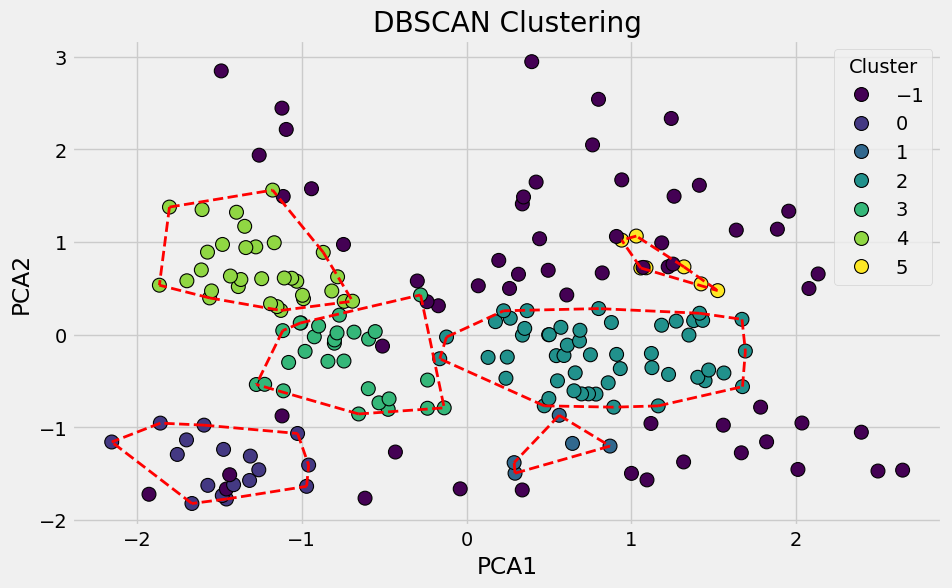

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Create a new DataFrame with PCA results and cluster labels
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, edgecolor='k')

# Draw convex hulls
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
    if cluster == -1:  # DBSCAN labels noise as -1
        continue
    points = pca_df[pca_df['Cluster'] == cluster][['PCA1', 'PCA2']].values
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=2)

plt.title('DBSCAN Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()



###4. Gaussian Mixture Model (GMM)

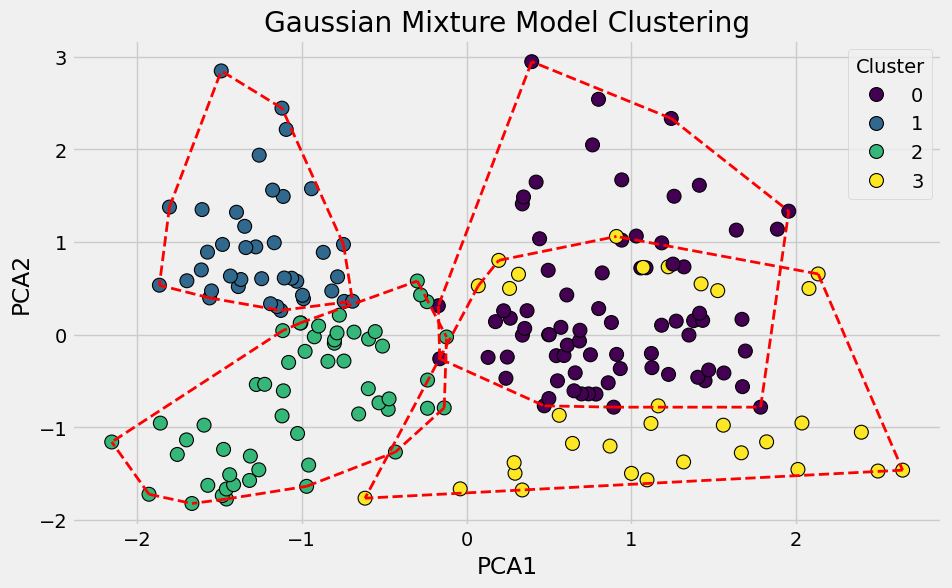

In [ ]:
from sklearn.mixture import GaussianMixture

# Apply Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
clusters = gmm.fit_predict(X_scaled)

# Create a new DataFrame with PCA results and cluster labels
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, edgecolor='k')

# Draw convex hulls
for cluster in range(4):
    points = pca_df[pca_df['Cluster'] == cluster][['PCA1', 'PCA2']].values
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=2)

plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()




###5. Mean Shift Clustering

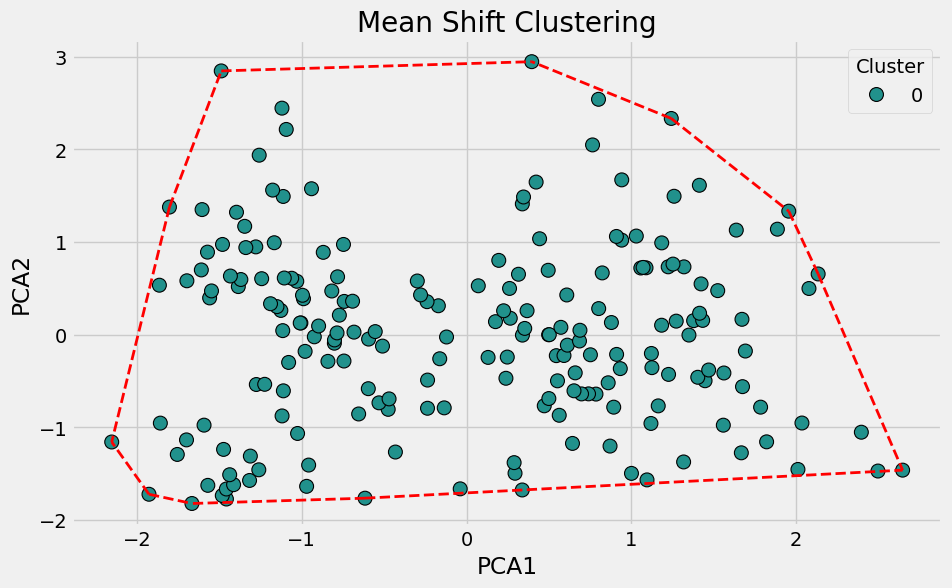

In [ ]:
from sklearn.cluster import MeanShift

# Apply Mean Shift Clustering
meanshift = MeanShift()
clusters = meanshift.fit_predict(X_scaled)

# Create a new DataFrame with PCA results and cluster labels
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, edgecolor='k')

# Draw convex hulls
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
    points = pca_df[pca_df['Cluster'] == cluster][['PCA1', 'PCA2']].values
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=2)

plt.title('Mean Shift Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()



### Sumary:

**Clustering Models Overview**

1. KMeans Clustering => Algorithm: Iteratively assigns points to the nearest centroid and then
updates the centroids based on the mean of the points assigned to each cluster.
>Advantages:
Simple and computationally efficient for large datasets.
Works well when clusters are compact and well-separated.
>
>Disadvantages:
Requires predefined number of clusters (k).
Sensitive to initialization and outliers.


---

2. Hierarchical Clustering => Algorithm: Builds a hierarchy of clusters either bottom-up (agglomerative) or top-down (divisive) by iteratively merging or splitting clusters based on distance metrics.
> Advantages:
Does not require a predefined number of clusters.
Can visualize dendrograms to understand relationships.
>
>Disadvantages:
Computationally expensive for large datasets.
Difficult to interpret for very large datasets.

---

3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
=>Algorithm: Groups together points that are closely packed together (dense regions) and marks points in low-density regions as outliers.
>Advantages:
Can find arbitrarily shaped clusters and handle noise.
Does not require predefined number of clusters.
>
> Disadvantages:
Sensitive to parameters (epsilon and minPts).
Not suitable for datasets with varying densities or complex geometries.

---

4. Gaussian Mixture Models (GMM)
=>Algorithm: Assumes that all data points are generated from a mixture of several Gaussian distributions with unknown parameters.
>Advantages:
Can model complex cluster shapes and incorporate covariance between features.
Provides probabilistic cluster assignments.
>
>Disadvantages:
Computationally expensive for large datasets.
Sensitive to initialization and may converge to local optima.


---
5. Mean Shift Clustering

>helps you find natural groups in data by moving points towards areas where there are more points, like people finding their way to the center of a crowd. It’s great when you don’t know how many groups to look for and when the groups have irregular shapes
